In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import seaborn as sns
sns.set(style='dark', font_scale=1.3)

import warnings
warnings.filterwarnings('ignore')

# <a href="https://mipt-stats.gitlab.io/courses/ad_mipt.html">Phystech@DataScience</a>


(a)  Cкачаем [датасет](https://www.kaggle.com/colearninglounge/predicting-pulsar-starintermediate) о предсказании пульсаров.





Пульсары &mdash; это космические объекты, излучающие в различных диапазонах длины волны. Согласно современным астрофизическим теориям, пульсары представляют собой вращающиеся нейтронные звезды, обладающие магнитным полем, наклоненным относительно оси вращения.

Пульсары представляют значительный научный интерес. Поэтому есть потребность в автоматическом обнаружении интересных объектов для ускорения процесса изучения. На практике почти все обнаружения вызваны радиочастотными помехами и шумом, что затрудняет поиск достоверных сигналов. В последнее время для автоматического обнаружения пульсаров начали применять машинное обучение. Актуальная задача сегодня &mdash; бинарная классификация объектов-кандидатов на предмет того, являются ли они пульсарами.

В используемом датасете есть как примеры ложных обнаружений, так и примеры реальных пульсаров, подтвержденные учеными. Данные получены в результате [The High Time Resolution Universe Pulsar Survey I](https://arxiv.org/abs/1006.5744).

Мы будем работать только с файлом `pulsar_data_train.csv`.

In [7]:
data = pd.read_csv("pulsar_data_train.csv")

Сигнал от пульсаров представляет собой периодические импульсы.

Для описания объекта используется integrated profile (интегральный профиль) &mdash; агрегирование сигнала за разные периоды вращения (<a target="_blank" href="http://ipta.phys.wvu.edu/files/student-week-2017/IPTA2017_KuoLiu_pulsartiming.pdf">ссылка</a>, слайд 11). У всех пульсаров разные интегральные профили, и обычно эта характеристика мало меняется во времени.
В данном датасете интегральный профиль также усреднен по частоте.

Кроме того, импульс приходит в разное время на разных частотах. Задержка от частоты к частоте вызвана наличием ионизированной межзвездной среды и называется дисперсией. Не путать с дисперсией в теории вероятностей.

С дисперсией связана еще одна характеристика объекта &mdash; DM-SNR кривая. Подробнее об этой характеристике можно почитать <a target="_blank" href="https://arxiv.org/pdf/1005.5068.pdf#:~:text=period-DM%20diagram%3B%20good%20agreement,pulsars%20in%20their%20candidate%20plots.)">в специализированных материалах</a>.

Обе характеристики, integrated profile и DM-SNR кривая, представляют собой одномерные функции.
При создании датасета значения функций были посчитаны в конечном количестве $n$ точек.
Фактически, были получены реализации выборки двух случайных величин.

Пусть $P = (p_1, \ldots p_n)$ &mdash; массив значений integrated profile.
Для него можно посчитать следующие статистики:

1.   Выборочное среднее $\bar p = \frac{1}{n}\sum \limits_{i=1}^n p_i$;
2.   Выборочное стандартное отклонение $\sqrt{\frac{1}{n}\sum \limits_{i=1}^n (p_i - \bar p)^2}$;
3. Выборочный коэффициент асимметрии (skewness);
4. Выборочный коэффициент эксцесса (kurtosis).

Для $D = (d_1, \ldots d_n)$, массива значений DM-SNR, аналогично.

Именно эти значения по массивам $P$ и $D$ являются признаками в данном датасете.

Про коэффициенты эксцесса и асимметрии можно посмотреть <a target="_blank" href="https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D1%8D%D1%84%D1%84%D0%B8%D1%86%D0%B8%D0%B5%D0%BD%D1%82_%D1%8D%D0%BA%D1%81%D1%86%D0%B5%D1%81%D1%81%D0%B0">здесь</a> и <a target="_blank" href="https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D1%8D%D1%84%D1%84%D0%B8%D1%86%D0%B8%D0%B5%D0%BD%D1%82_%D0%B0%D1%81%D0%B8%D0%BC%D0%BC%D0%B5%D1%82%D1%80%D0%B8%D0%B8">здесь</a>, формулы для выборочных коэффициентов асимметрии и эксцесса можно найти в английской версии этих статей.

<a target="_blank" href="https://arxiv.org/pdf/1603.05166.pdf">Статья</a> с подробным описанием процесса генерации данных.










In [ ]:
data.head()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,121.156250,48.372971,0.375485,-0.013165,3.168896,18.399367,7.449874,65.159298,0.0
1,76.968750,36.175557,0.712898,3.388719,2.399666,17.570997,9.414652,102.722975,0.0
2,130.585938,53.229534,0.133408,-0.297242,2.743311,22.362553,8.508364,74.031324,0.0
3,156.398438,48.865942,-0.215989,-0.171294,17.471572,NaN,2.958066,7.197842,0.0
4,84.804688,36.117659,0.825013,3.274125,2.790134,20.618009,8.405008,76.291128,0.0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12528 entries, 0 to 12527
Data columns (total 9 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0    Mean of the integrated profile                12528 non-null  float64
 1    Standard deviation of the integrated profile  12528 non-null  float64
 2    Excess kurtosis of the integrated profile     10793 non-null  float64
 3    Skewness of the integrated profile            12528 non-null  float64
 4    Mean of the DM-SNR curve                      12528 non-null  float64
 5    Standard deviation of the DM-SNR curve        11350 non-null  float64
 6    Excess kurtosis of the DM-SNR curve           12528 non-null  float64
 7    Skewness of the DM-SNR curve                  11903 non-null  float64
 8   target_class                                   12528 non-null  float64
dtypes: float64(9)
memory usage: 881.0 KB


В этом датасете в некоторых столбцах есть пропуски в данных. Об этом говорит то, что значение Non-Null Count в таблице выше не равно количеству строк для некоторых столбцов. Чтобы не усложнять себе жизнь, пока просто не будем брать эти столбцы для анализа.

Столбец `target_class` отвечает за целевую переменную — индикатор того, является ли объект пульсаром.

In [35]:
needed_columns = [' Mean of the integrated profile',
       ' Standard deviation of the integrated profile',
       ' Skewness of the integrated profile', ' Mean of the DM-SNR curve',
       ' Excess kurtosis of the DM-SNR curve']  # используем только эти столбцы

X = data[needed_columns]

In [36]:
y = data['target_class']

(b) Проведите визуальный анализ данных. Например, можете построить оценки плотности по каждому признаку
отдельно для каждого класса. Какие признаки лучше всего разделяют классы?

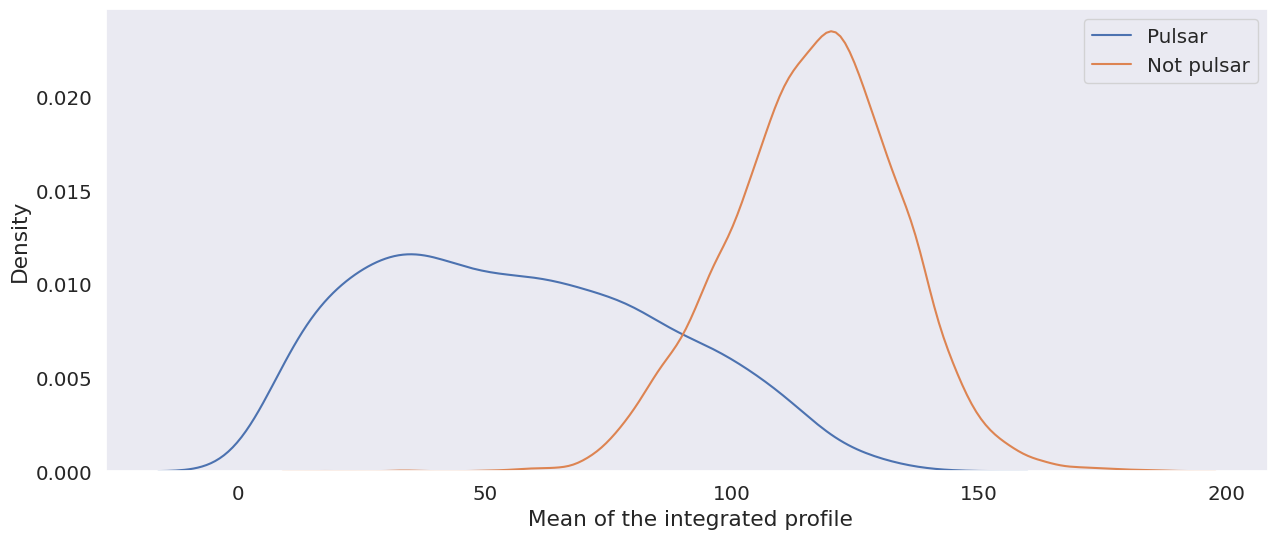

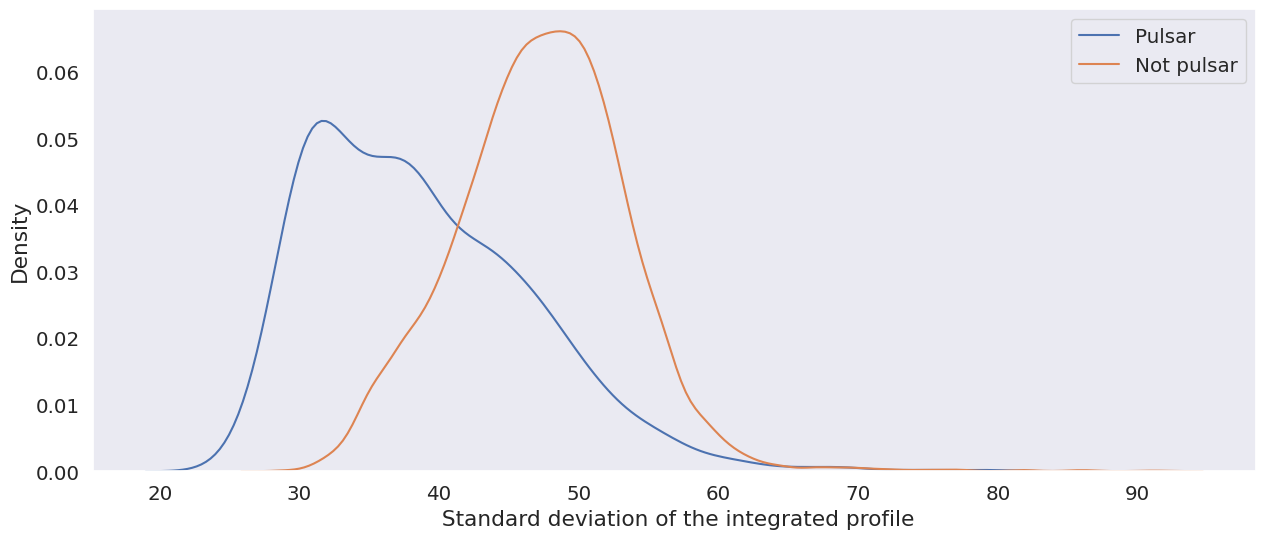

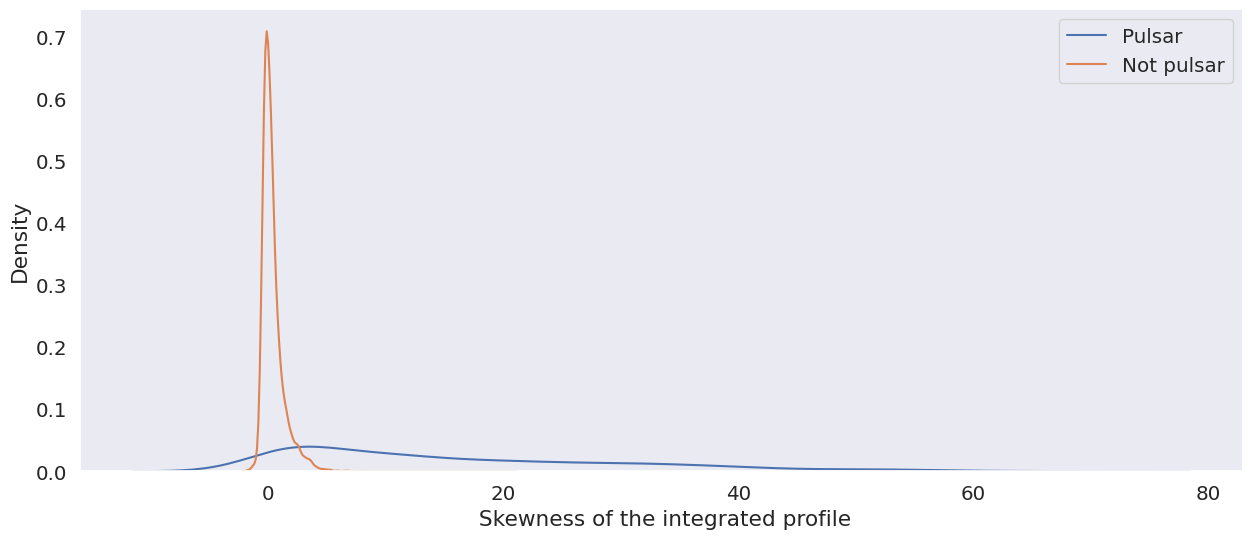

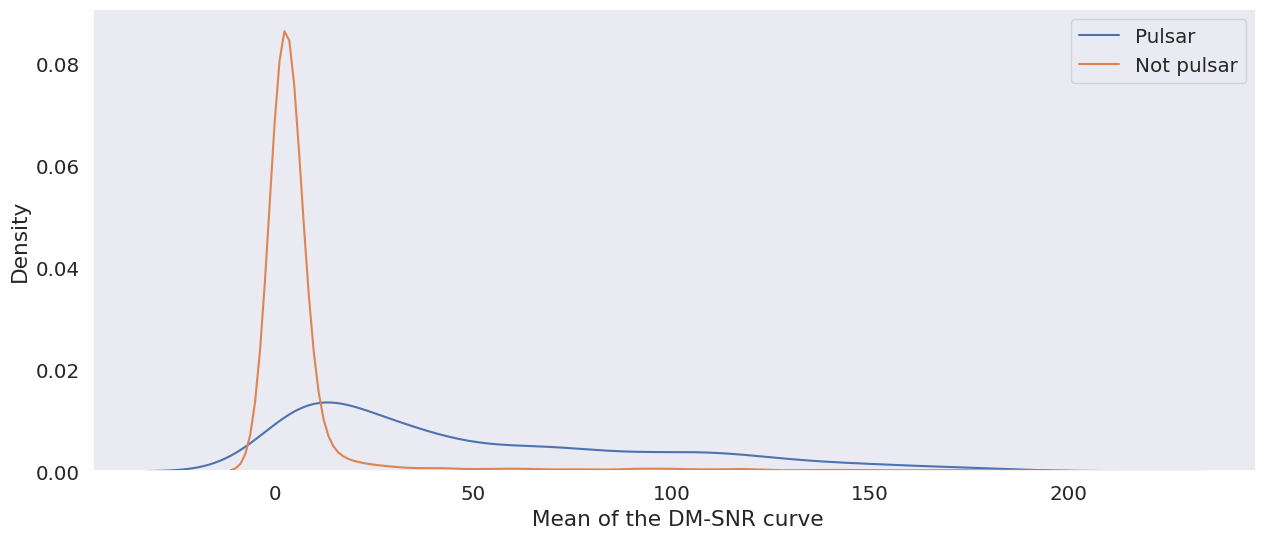

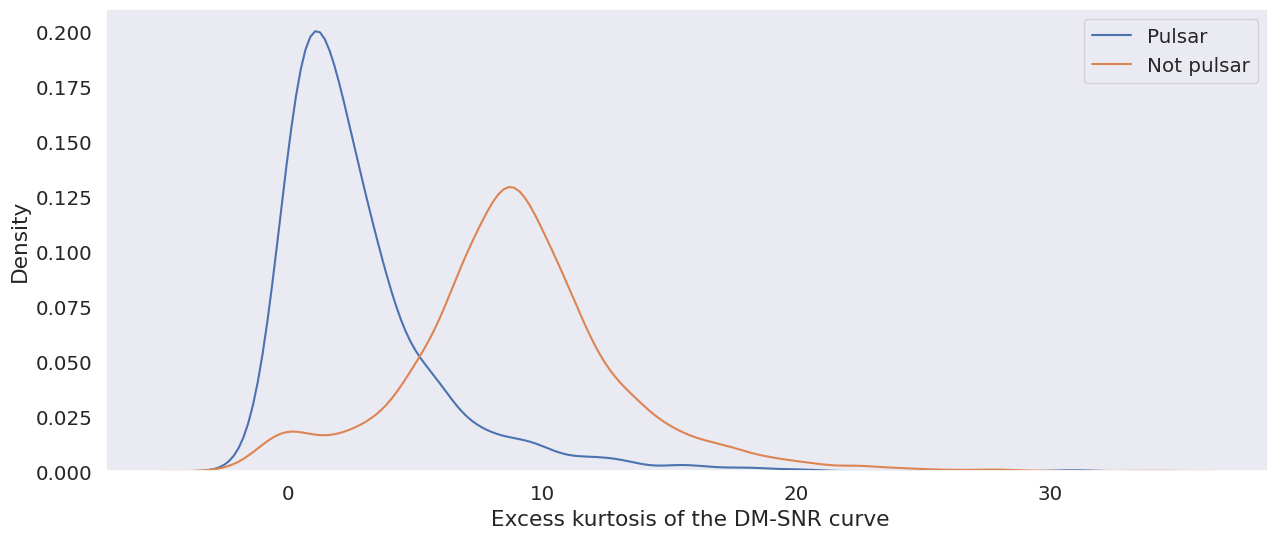

In [37]:

n = len(needed_columns)
for i in range(n):
  plt.figure(figsize=(15,6))
  a = needed_columns[i]
  sns.kdeplot(data[y == 1][a], label='Pulsar')
  sns.kdeplot(data[y == 0][a], label='Not pulsar')
  plt.legend()

**Вывод**
' Skewness of the integrated profile', ' Mean of the DM-SNR curve' на данных графиках легче всего различить признаки, так как их пики имеют большую разницу между друг другами.



У признаков должен быть одинаковы масштаб. Почему? Как этого добиться?

**Ответ:** Да, должен быть одинаковый масштаб, так как коэффициенты долдны иметь одинаковый вклад. Это можно добиться, если мы отнимем среднее, разделить на корень из дисперсии

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
std = preprocessing.StandardScaler()
X_train_stand = std.fit_transform(X_train)
X_test_stand = std.transform(X_test)

 В данных есть пропуски. Сколько их? Уберите данные с пропусками.

In [29]:
X.isnull().sum()

 Mean of the integrated profile                  0
 Standard deviation of the integrated profile    0
 Skewness of the integrated profile              0
 Mean of the DM-SNR curve                        0
 Excess kurtosis of the DM-SNR curve             0
dtype: int64

нет пропусков

Добавьте  свободный член.   Разделите выборку на обучающую и тестовую часть случайным образом в соотношении 4:1.

In [39]:
lg = LogisticRegression(fit_intercept=True)


(d)  Обучите логистическую регрессию по всем признакам.  

In [40]:

lg.fit(X_train, y_train)

LogisticRegression()

Напечатайте коэффициенты модели. Сделайте выводы.

In [44]:
lg.coef_, lg.intercept_

(array([[-0.05204257,  0.08267663,  0.60332365, -0.01402278, -0.3127705 ]]),
 array([0.01978702]))

Можно сделать ввывод, что данные признаки не имеют большее значение, так как они малы. Наибольший вклад из этих признаков вносят 3,5

(e) Для  объектов из тестовой выборки оцените вероятность того, что это пульсар и сделайте предсказания. Насколько точны
ваши прогнозы?
Реализуйте известные вам метрики качества и выведите их значения. Какие метрики вам кажутся важнее в данной задаче?


In [49]:
from re import M
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, accuracy_score
y_pred = lg.predict(X_test)

MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
MAPE =  mean_absolute_percentage_error(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f'MAE: {MAE}', 
      f'MSE: {MSE}', 
      f'MAPE: {MAPE}', 
      f'accuracy: {accuracy}' )


MAE: 0.02753391859537111 MSE: 0.02753391859537111 MAPE: 16174140720803.883 accuracy: 0.9724660814046289


Можно заметить, что значение MAPE очень большое, поэтому на него можно не ориентироваться. 
МАЕ и MSE имеют равные маленькие значения

  Можно сделать вывод, что для логистической регрессии лучше использовать предназначенные для нее метрики качества.

